Ovaj program približava korišćenje konvolutivnih neuronskih mreža. Zadatak koji se rešava je određivanje broja prstiju na slici na kojoj je prikazana šaka. 

Umesto dosadašnje sumarizacije mreže u tekstualnom formatu, koristiće se grafovski prikaz modela neuronske mreže. Za to ce na trebati **pydot** i **graphviz** Python paketi koji se mogu instalirati sa 

conda install pydot

conda install graphviz

Ova dva paketa omogucavaju rad sa DOT jezikom koji se koristi za opis grafova. 

In [1]:
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.


In [2]:
import numpy as np
import h5py
from matplotlib import pyplot as plt

In [3]:
from keras.layers import *
from keras.models import *
from keras.optimizers import Adam

#### Priprema skupa za ucenje.

In [4]:
# slike sake koji se koriste za treniranje su sadrzane u train_signs.h5 datoteci 
# sledeca funkcija omogucava ucitavanje i ispis osnovnih informacija o skupu podataka i, 
# po potrebi, prikaz ucitanih slika

def load_train_dataset(path='datasets/train_signs.h5', preview=5):

    train_dataset = h5py.File(path, 'r')
    
    train_x = np.array(train_dataset['train_set_x'])
    train_y = np.array(train_dataset['train_set_y'])
    classes = np.array(train_dataset['list_classes'])

    print('train_x size: {}'.format(train_x.shape))
    print('train_y size: {}'.format(train_y.shape))
    print('number of image classes: {}'.format(len(classes)))

    for i in range(0, preview):
        index = np.random.randint(train_x.shape[0])
        plt.figure()
        plt.suptitle(train_y[index])
        plt.imshow(train_x[index])

    return train_x, train_y, len(classes)

In [5]:
# funkcija koja se koristi za one-hot kodiranje ciljne promenljive

# ideja je da se slici na kojoj se ne nalazi ni jedan prist pridruzi vektor (0, 0, 0, 0, 0), 
# slici na kojoj se nalazi jedan prst vektor (1, 0, 0, 0, 0)
# slici na kojoj se nalaze dva prsta vektor (0, 1, 0, 0, 0)
# ...
# slici na kojoj se nalazi jedan prst vektor (0, 0, 0, 0, 1)

# funkcija pokriva opsti slucaj za skup koji sadrzi C razlicitih vrednosti 
def one_hot(y, C):
    y_one_hot = np.zeros((y.shape[0], C))
    y_one_hot[np.arange(0, y.shape[0]), y] = 1
    
    return y_one_hot

train_x size: (1080, 64, 64, 3)
train_y size: (1080,)
number of image classes: 6


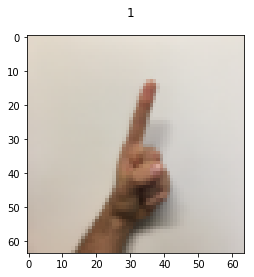

In [6]:
train_x, train_y, C = load_train_dataset(preview=1)

Konvolutivne neuronske mreze daju bolje rezultate ukoliko su vrednosti sa kojima rade normalizovane. 

In [7]:
train_x = train_x / 255

In [8]:
train_x.shape

(1080, 64, 64, 3)

In [9]:
train_y = one_hot(train_y, C)

In [10]:
train_y.shape

(1080, 6)

#### Priprema skupa za testiranje. 

In [12]:
# slike sake koji se koriste za testiranje su sadrzane u test_signs.h5 datoteci 
# sledeca funkcija omogucava ucitavanje skupova podataka 

def load_test_dataset(path='datasets/test_signs.h5'):
    test_dataset = h5py.File(path, 'r')
    
    test_x = np.array(test_dataset['test_set_x'])
    test_y = np.array(test_dataset['test_set_y'])

    return test_x, test_y

In [13]:
test_x, test_y = load_test_dataset()

In [14]:
test_x = test_x / 255

In [15]:
test_x.shape

(120, 64, 64, 3)

In [16]:
test_y = one_hot(test_y, C) 

In [17]:
test_y.shape

(120, 6)

#### Kreiranje modela. 

U ovom primeru ce se koristiti funkcionalni API Keras biblioteke. Input i Output slojevi predstavljaju tenzore, dok svi drugi slojevi predstavljaju funkcije koje kao ulaz primaju tenzore i kao rezultat generisu tenzore. 

Ova vrsta API-ja se koristi u slucajevima kada se kreiraju nesekvencijalni modeli.  

In [18]:
def build_model(image_shape, c):
    x_input = Input(image_shape)
    
    x = ZeroPadding2D(padding=(1,1))(x_input)
    x = Conv2D(32, (3, 3), strides=(1, 1))(x)
    x = BatchNormalization(axis=3)(x)
    x = Activation('relu')(x)
    
    x = MaxPool2D((2,2))(x)

    x = ZeroPadding2D(padding=(1,1))(x)
    x = Conv2D(64, (3, 3), strides=(1, 1))(x)
    x = BatchNormalization(axis=3)(x)
    x = Activation('relu')(x)
    
    x = MaxPool2D((2,2))(x)

    x = ZeroPadding2D(padding=(1,1))(x)
    x = Conv2D(16, (3, 3), strides=(1, 1))(x)
    x = BatchNormalization(axis=3)(x)
    x = Activation('relu')(x)
    
    x = Flatten()(x)
    
    x = Dropout(rate=0.1)(x)
    x = Dense(units=1024, activation='relu')(x)
    y = Dense(c, activation='softmax')(x)
    
    # Model ocekuje odgovarajuci ulaz i odgovarajuci izlaz, a na osnovu transformacija koje su koriscene da bi se 
    # od ulaza dobio odgovarajuci izlaz kreira medjuslojeve  
    return Model(inputs=x_input, outputs=y, name = 'sign_cnn')

In [19]:
image_shape = train_x [0].shape
sign_cnn = build_model(image_shape, C)

In [20]:
sign_cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 66, 66, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 34, 34, 32)        0         
__________

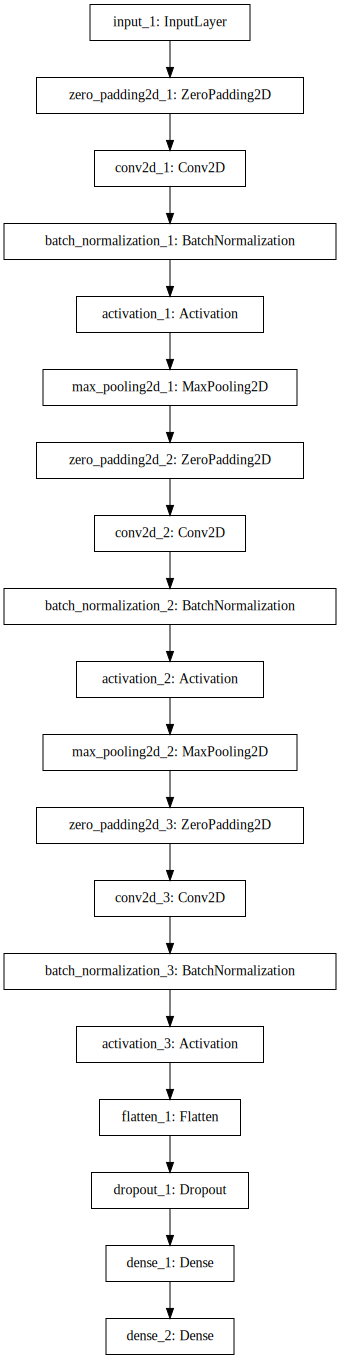

In [21]:
# ili u formi grafa 
display(SVG(model_to_dot(sign_cnn).create(prog='dot', format='svg')))

In [22]:
sign_cnn.compile(optimizer=Adam(lr=0.00075), loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
sign_cnn.fit(train_x, train_y, epochs=10, batch_size=64)

Epoch 1/10
1080/1080 [==============================] - 29s 27ms/step - loss: 6.4421 - acc: 0.3167
Epoch 2/10
1080/1080 [==============================] - 28s 26ms/step - loss: 5.6018 - acc: 0.5769
Epoch 3/10
1080/1080 [==============================] - 28s 26ms/step - loss: 5.4439 - acc: 0.6417
Epoch 4/10
1080/1080 [==============================] - 28s 26ms/step - loss: 5.3928 - acc: 0.6602
Epoch 5/10
1080/1080 [==============================] - 28s 25ms/step - loss: 5.3799 - acc: 0.6667
Epoch 6/10
1080/1080 [==============================] - 28s 26ms/step - loss: 5.3760 - acc: 0.6667
Epoch 7/10
1080/1080 [==============================] - 33s 31ms/step - loss: 5.3753 - acc: 0.6667
Epoch 8/10
1080/1080 [==============================] - 30s 28ms/step - loss: 5.3743 - acc: 0.6667
Epoch 9/10
1080/1080 [==============================] - 28s 26ms/step - loss: 5.3743 - acc: 0.6667
Epoch 10/10
1080/1080 [==============================] - 27s 25ms/step - loss: 5.3739 - acc: 0.6667


In [25]:
loss, accuracy = sign_cnn.evaluate(test_x, test_y)

120/120 [==============================] - 1s 12ms/step


In [26]:
print('Test loss: {}'.format(loss))
print('Test accuracy: {}'.format(accuracy))

Test loss: 5.444115861256917
Test accuracy: 0.6583333293596904
